# Data collection and descriptive analysis
From [Open Food Facts](https://world.openfoodfacts.org/) we have a 1.7 GB `.csv` file which contains information of over 600 000 unique food products. Our purpose with this notebook is to explore this dataset and compile the availible information into one/several files of a smaller format containing only what is needed and can be used for our project.

In [3]:
import pandas as pd
import numpy as np
import functools
import re
import pygal
import matplotlib.pyplot as plt
import seaborn as sns
from pygal.style import Style
import math

# Health indices

In [2]:
index = ['france','us']
columns = ['Population',
    'Life expectancy at birth',
    'Life expectancy at age 60',
    'Healty life expectancy (HALE) at birth' ,
    'Healty life expectancy (HALE) at age 60',
    'Nutritional deficiencies',
    'Protein-energy malnutrition',
    'Iodine deficiency',
    'Iron-deficiency anaemia',
    'Other nutritional deficiencies',
    'Diabetes mellitus',
    'Ischaemic heart disease',
    'overweight among adults',
    'obesity among adults',
    'overweight among children and adolescents',
    'obesity among children and adolescents',
    'Mean body mass index adults',
    'Mean body mass index 5-19 years',
    'Blood glucose' ]
data = np.array([
    [64721, 82.9, 21.8, 68.5, 16.9, 0.006518, 0.005111, 0.000001, 0.001236, 0.000155, 0.019121, 0.095569, 59.5,
     23.2, 28.9, 8.1, 25.6, 19.5, 5.9],
    [322180, 78.5, 23.3, 68.5, 17.8, 0.002986, 0.001966, 0.000001, 0.000924, 0.000096, 0.026175, 0.155290, 67.9,
     37.3, 41.2, 21.4, 29.1, 21.5, 7.3]
])
healthIndices= pd.DataFrame(data, index=index, columns=columns)
healthIndices

,Population,Life expectancy at birth,Life expectancy at age 60,Healty life expectancy (HALE) at birth,Healty life expectancy (HALE) at age 60,Nutritional deficiencies,Protein-energy malnutrition,Iodine deficiency,Iron-deficiency anaemia,Other nutritional deficiencies,Diabetes mellitus,Ischaemic heart disease,overweight among adults,obesity among adults,overweight among children and adolescents,obesity among children and adolescents,Mean body mass index adults,Mean body mass index 5-19 years,Blood glucose
france,64721.0,82.9,21.8,68.5,16.9,0.006518,0.005111,0.000001,0.001236,0.000155,0.019121,0.095569,59.5,23.2,28.9,8.1,25.6,19.5,5.9
us,322180.0,78.5,23.3,68.5,17.8,0.002986,0.001966,0.000001,0.000924,0.000096,0.026175,0.155290,67.9,37.3,41.2,21.4,29.1,21.5,7.3


In [5]:
data_folder = "./data/"

In [4]:
database = pd.read_csv(data_folder + "en.openfoodfacts.org.products.csv", sep='\t', dtype=object)

We take a look at the data:

In [5]:
database.describe()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
count,696770,696770,696801,696800,696794,696804,696804,670800,77415,194249,...,344,140760,140760,2,1,27,1,14,33,13
unique,696731,696733,6656,562201,562207,551516,551515,479331,58231,22537,...,211,56,56,2,1,18,1,10,19,8
top,0638097545939,http://world-en.openfoodfacts.org/product/3280...,kiliweb,1489055829,2017-03-09T10:37:09Z,France,en:france,Comté,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,0,0,0,3,2,0.069,1.6e-05,4,0.02,0.007
freq,2,2,312135,20,20,29,31,451,181,7881,...,82,7338,10150,1,1,4,1,3,6,2


We have a lot of different types of data, 173 columns. This means that the `describe` method does not really give us information that is easy to survey - we need to explore the data in another way. 

# Finding the column with the country data
We are interested in doing out analysis based on which country the food item comes from. We therefore filter the data to find the columns which starts with the string `countr` for "countries":

In [6]:
filter_col = [col for col in database if col.startswith('countr')]
filter_col

['countries', 'countries_tags', 'countries_en']

We have three different columns regarding country data. Let's try to find out which one is relevant for us. A guess is that it is the `countries_en` column that we need, since the name presumably means that the column contain data of the origin country in English.

Looking at the `countries` column, we notice that there are duplicates:

In [7]:
database.countries.value_counts().head(5)

en:france    205162
France       179274
US           168473
en:FR         28054
Suisse         9097
Name: countries, dtype: int64

France appears several times! By comparing the number of unique values for each of the three different columns we see that the other two columns contain less than half the number of unique values:

In [8]:
for col in filter_col:
    print("Number of unique country labels in column '{}': ".format(col) + str(database[col].value_counts().shape[0]))


Number of unique country labels in column 'countries': 3227
Number of unique country labels in column 'countries_tags': 1227
Number of unique country labels in column 'countries_en': 1227


Taking a look at `countries_tags` and `countries_en` gives us the information that they are basically identical, just with a different format for each country:

In [9]:
database.countries_tags.value_counts().head(6)

en:france               421492
en:united-states        173575
en:switzerland           13463
en:germany               11845
en:france,en:germany      6309
en:spain                  6234
Name: countries_tags, dtype: int64

In [10]:
database.countries_en.value_counts().head(6)

France            421492
United States     173575
Switzerland        13463
Germany            11845
France,Germany      6309
Spain               6234
Name: countries_en, dtype: int64

Because of this, we decide to use the `countries_en` column. We note the format of the column, that each country starts with a capital letter and that if there are several countries they are separated by a comma without and whitespace.

# Filtering out France and the United States
We are only interested in comparing France against the United States. Because of this, we want to compile the rows of the database which contain data for these two countries into two new dataframes respectively.

In [11]:
# na=False drops all the rows where countries_en is NaN
france_data = database[database.countries_en.str.contains("France", na=False)]
us_data = database[database.countries_en.str.contains("United States", na=False)]

# Filtering out relevant columns

Relevant columns are columns with values for several products. We define that a column is relevant to look at if it has at least 10 000 defined values.

In [12]:
columns10000 = ((france_data.count() > 10000) & (us_data.count() > 10000))

In [13]:
france_data.columns[columns10000]

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'brands',
       'brands_tags', 'countries', 'countries_tags', 'countries_en',
       'ingredients_text', 'serving_size', 'serving_quantity', 'additives_n',
       'additives', 'additives_tags', 'additives_en',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'states', 'states_tags',
       'states_en', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g'],
      dtype='object')

From the resulting columns, we will use the ones relevant for nutrition. These are the ones with values per 100g, servings and the product names. In addition to these, we will save the column "category", as we will use it to categorise our data. We will also save some additional vitamins and minerals, as well as two columns with nutrition facts. An overview of all columns can be found here: https://static.openfoodfacts.org/data/data-fields.txt

In [14]:
re_columns = ['product_name', 'brands', 'brands_tags', 'ingredients_text', 'serving_size', 'categories',
              'categories_tags', 'categories_en',
              'serving_quantity', 'energy_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g', 'fat_100g',
              'saturated-fat_100g','monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g',
              'omega-6-fat_100g','omega-9-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'fiber_100g',
              'sodium_100g', 'vitamin-a_100g','vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g',
              'vitamin-b1_100g','vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g',
              'vitamin-b12_100g',
              'biotin_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g',
              'copper_100g', 'manganese_100g', 'fluoride_100g', 'selenium_100g', 'chromium_100g', 'molybdenum_100g',
              'iodine_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g']

In [15]:
france_data = france_data[re_columns]
us_data = us_data[re_columns]

# Cleaning data
### Drop rows which are unusable
Rows which only has NaN, and rows which does not have either any of the three food item category columns (`categories_en`, `categories` or `categories_tags`) or the `product name` category are not usable for us as we would not be able to use them in any comparison later on. For this reason we remove them:

In [16]:
# drop rows with all NaNs.
france_data.dropna(how='all', inplace=True)
us_data.dropna(how='all', inplace=True)

In [17]:
# drop rows if there are NaNs in all of the columns in `cols`
cols = ['categories_en', 'categories', 'categories_tags', 'product_name']
france_data.dropna(subset=cols, how='all', inplace=True)
us_data.dropna(subset=cols, how='all', inplace=True)

### Inspection of values

We continue the cleaning cleaning by reading calculating number of rows in the two dataframes.

In [18]:
# number of products
print("There are %d products sold in France" % len(france_data))
print("There are %d products sold in the USA" % len(us_data))

There are 438674 products sold in France
There are 174595 products sold in the USA


In [19]:
#us_data.to_csv(data_folder + "us_data.csv")
#france_data.to_csv(data_folder + "france_data.csv")

#france_data2 = pd.read_csv(data_folder + 'france_data.csv')
#us_data2 = pd.read_csv(data_folder + 'us_data.csv')

We will start to look at the data by considering the max and min of each column.

In [20]:
pd.options.display.float_format = '{:20.2f}'.format

# Convert to numeric columns where possible, otherwise ignore errors
france_data = france_data.apply(pd.to_numeric, errors='ignore')
us_data = us_data.apply(pd.to_numeric, errors='ignore')

france_data.max(numeric_only=True)

serving_quantity                     2601059.00
energy_100g                          1841546.00
proteins_100g                           4400.00
carbohydrates_100g                     72000.00
sugars_100g                            68000.00
fat_100g                                 915.00
saturated-fat_100g                       612.00
monounsaturated-fat_100g                  82.00
polyunsaturated-fat_100g                  75.00
omega-3-fat_100g                         485.00
omega-6-fat_100g                          71.00
omega-9-fat_100g                          75.00
trans-fat_100g                            31.00
cholesterol_100g                          28.00
fiber_100g                        5570000000.00
sodium_100g                              800.00
vitamin-a_100g                           800.00
vitamin-d_100g                             8.00
vitamin-e_100g                            22.90
vitamin-k_100g                             0.14
vitamin-c_100g                          

The max is out of range for a lot of the columns with values of a 100g. We will clean these columns by assuming that the values should be in the range 0 to 100.

In [21]:
def clean_with_range(df, column_names, max_value, min_value):
    for column in column_names:
        mask_max = df[column] > max_value
        mask_min = df[column] < min_value
        df.loc[mask_max, column] = np.nan
        df.loc[mask_min, column] = np.nan
    return df

In [22]:
numeric_columns = france_data.select_dtypes(include=[np.number]).columns.tolist()
columns_to_clean = [x for x in numeric_columns if x not in ['Unnamed: 0', 'energy_100g']]
france_data = clean_with_range(france_data, columns_to_clean, 100, 0)
# use same columns for the usa
us_data = clean_with_range(us_data, columns_to_clean, 100, 0)

Below we can see the cleaned max values.

In [23]:
france_data.max()

serving_quantity                         100.00
energy_100g                          1841546.00
proteins_100g                            100.00
carbohydrates_100g                       100.00
sugars_100g                              100.00
fat_100g                                 100.00
saturated-fat_100g                       100.00
monounsaturated-fat_100g                  82.00
polyunsaturated-fat_100g                  75.00
omega-3-fat_100g                          68.00
omega-6-fat_100g                          71.00
omega-9-fat_100g                          75.00
trans-fat_100g                            31.00
cholesterol_100g                          28.00
fiber_100g                               100.00
sodium_100g                               98.43
vitamin-a_100g                            73.00
vitamin-d_100g                             8.00
vitamin-e_100g                            22.90
vitamin-k_100g                             0.14
vitamin-c_100g                          

# Downsampling the France dataset
The France dataset contains a considerate amount more entries than the US dataset. Because of this, we downsample the France dataset at this stage so that both datasets have the same number of entries.

In [24]:
print("Size of France dataset: " + str(france_data.shape[0]))
print("Size of US dataset: "+ str(us_data.shape[0]))

Size of France dataset: 438674
Size of US dataset: 174595


In [25]:
france_data = france_data.sample(us_data.shape[0])
print("Size of France dataset: " + str(france_data.shape[0]))
print("Size of US dataset: "+ str(us_data.shape[0]))

Size of France dataset: 174595
Size of US dataset: 174595


# Define categories for comparisons
For doing comparisons between the US and France we need to categorize the data into comparable parts. As seen in the data there are already 3 columns containing (possibly overlapping) category information for the food items. These category columns needs to be investigated further, which we do starting with looking at the entries in each category which are most common:

In [26]:
france_data.categories.value_counts().head(5)

en:beverages                                  2706
en:fats                                        666
en:milks                                       257
Chocolats noirs                                240
Snacks sucrés,Biscuits et gâteaux,Biscuits     142
Name: categories, dtype: int64

In [27]:
france_data.categories_en.value_counts().head(5)

Beverages,Non-Alcoholic beverages           2006
Fats                                         697
Beverages,Sugared beverages                  647
Sugary snacks,Chocolates,Dark chocolates     421
Dairies,Milks                                382
Name: categories_en, dtype: int64

In [28]:
france_data.categories_tags.value_counts().head(5)

en:beverages,en:non-alcoholic-beverages              2006
en:fats                                               697
en:beverages,en:sugared-beverages                     647
en:sugary-snacks,en:chocolates,en:dark-chocolates     421
en:dairies,en:milks                                   382
Name: categories_tags, dtype: int64

We see that the three columns are very similar, but there are some differences between them. An example is that for the most common entry, the categories `categories_en` and `categories_tags` provide additional information in the form of the tag "Non-Alcoholic beverages". On the other hand, the column `categories` provides us with the names of things in French. Having additional information increases the chance that an item is found and correctly identified as being in a certain category.

As the two columns `categories_en` and `categories_tags` contain the same information (just in a slightly different format), we can choose to use only one, the `categories_en` column. This gives us two categories to use, `categories` and `categories_en`.

It might be a good strategy for us to search through both of the two categories when we want find items for a comparison, for example searching for items with the keywords "yoghurt" and "dairies", especially since it would not be taking any considerable amount of time to do (the computations are not very heavy).

We will also be using the `product_name` column for finding items that match certain categories, as the names can be descriptive and contain strings that are associated with a certain food category. An example of the most common food items in the US can be seen here:

In [29]:
us_data.product_name.value_counts().head(10)

Ice Cream                 408
Extra Virgin Olive Oil    296
Potato Chips              281
Premium Ice Cream         226
Beef Jerky                165
Pinto Beans               162
Popcorn                   150
Salsa                     149
Cookies                   144
Tomato Sauce              140
Name: product_name, dtype: int64

We define a function which takes a dataframe and a list of strings and returns a dataframe with the rows of that original dataframe in which the string exists in any of the four columns `categories_en`, `categories`, `categories_tags` or `product name`. 

In [10]:
def select_entries(df, tag_list):
    cols = ['categories_en', 'categories', 'product_name']
    combinations = [df[col].str.contains(tag, na=False, flags=re.IGNORECASE)
                    for tag in tag_list for col in cols]
    mask = functools.reduce(lambda x, y: x | y, combinations)
    return df[mask]

In [31]:
ice_cream = select_entries(us_data, ['Ice Cream'])
ice_cream.head(5)

,product_name,brands,brands_tags,ingredients_text,serving_size,categories,categories_tags,categories_en,serving_quantity,energy_100g,...,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
615,"Ice Cream, Vanilla",Lactaid,lactaid,"Milk, cream, sugar, corn syrup, guar gum, locu...",71 g (0.5 cup),NaN,NaN,NaN,71.00,883.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
616,"Ice Cream, Butter Pecan",Lactaid,lactaid,"Milk, cream, sugar, corn syrup, pecans (pecans...",71 g (0.5 cup),NaN,NaN,NaN,71.00,1000.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2629,"Ice Cream, Vanilla Bean",Private Selection,private-selection,"Milk, cream, sugar, corn syrup, whey protein c...",93 g (0.5 cup),NaN,NaN,NaN,93.00,946.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2630,"Ice Cream, Classic Country Vanilla",Private Selection,private-selection,"Milk, cream, sugar, corn syrup, egg yolks, nat...",93 g (0.5 cup),NaN,NaN,NaN,93.00,946.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2631,"Ice Cream, Denali Extreme Moose Tracks",Private Selection,private-selection,"Ice cream - milk, cream, sugar, corn syrup, co...",85 g (0.5 cup),NaN,NaN,NaN,85.00,1230.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [32]:
select_entries(us_data, ['Ice Cream']).shape

(3131, 50)

Here we see that the number of items related to the word `Ice Cream` in the data for USA is as many as 3131. As this is more than 6 times more items than what we found for `Ice Cream` in the `product_name` category we can therefore use this data if we want to find the products with the most entries in the database, e.g. the food item type with the most variants.

This function lets us easily find all of the relevant rows to a category we define by our own. The categories we will use are “Dairy”, “Snacks”, “Bread and Dry goods”, "Fats" and “Meat, Poultry, Fish, Seafood, etc.”

We also define a function for omitting rows with cerain words from the columns, including an option to omit rows which have certain ingredients.

In [11]:
def clean_categories(df, wrong_strings, wrong_ingredients=[]):
    cols = ['categories_en', 'categories', 'product_name']
    combinations = [df[col].str.contains(wrong, na=False, flags=re.IGNORECASE)
                    for wrong in wrong_strings for col in cols]
    ingredient_combinations = [
        df['ingredients_text'].str.contains(
            wrong, na=False, flags=re.IGNORECASE
        )
        for wrong in wrong_ingredients
    ]
    mask = functools.reduce(
        lambda x, y: x | y, combinations + ingredient_combinations
    )
    return df[~mask]

# Saving data
We finish by writing the divided and curated data into two csv-files, one for France and one for the US. This yields two files of the much more managable size of around 100 MB each, compared to the original 1.7 GB.

In [39]:
france_data = france_data.reset_index(drop=True)
us_data = us_data.reset_index(drop=True)
us_data.to_csv(data_folder + "us_data.csv")
france_data.to_csv(data_folder + "france_data.csv")

# Data category analysis
As mentioned before, the categories we will divide the data set into and investigate are: “Dairy”, “Snacks”, “Bread and Dry goods”, "Fats" and “Meat, Poultry, Fish, Seafood, etc.”. In the following, we filter out the data into the categories using the already defined functions `select_entries` and `clean_categories`. We then explore the resulting data and plot the interesting metrics, saving the plots we want to use in our data story using the library `pygal`.

## Read data
We read in the data we saved. The reason for the save is to create a "checkpoint", to be able to start again in the middle of the notebook

In [132]:
france = pd.read_csv(data_folder + "france_data.csv", sep=',', dtype=object)
us = pd.read_csv(data_folder + "us_data.csv", sep=',', dtype=object)

## Category: Dairy

We define the words which are dairy-related and non-dairy-related, respectively:

In [184]:
dairy_words = ["dairy","milk","cream","cheese","yaourt","fromage","lait","yog", "creme"]
non_dairy_words = ["dairy free","non dairy","dairy-free","milk chocolat","cheeseburger",
                   "bacon","sandwich", "pasta","macaroni","non-dairy"," pain ", "beurre", " cake ",
                   "au lait" ]

We now use the `select_entries` function to filter out the entries in the database that are related to dairy.

In [185]:
france_dairy = select_entries(france, dairy_words)
print("Dairy related items in France before cleaning: " + str(france_dairy.shape[0]))
us_dairy = select_entries(us, dairy_words)
print("Dairy related items in US before cleaning: " + str(us_dairy.shape[0]))


Dairy related items in France before cleaning: 15579
Dairy related items in US before cleaning: 26866


We use the `clean_categories` function to remove food items unrelated to dairy, based on words that should not be in a food item's category/product name.

In [186]:
france_dairy = clean_categories(france_dairy, non_dairy_words)
print("Dairy related items in France after cleaning: " + str(france_dairy.shape[0]))
us_dairy = clean_categories(us_dairy, non_dairy_words)
print("Dairy related items in US after cleaning: " + str(us_dairy.shape[0]))

Dairy related items in France after cleaning: 11706
Dairy related items in US after cleaning: 23086


### Distribution of subcategories within the dairy category

We want to investigate what different kinds of subcategories exist within the dairy category. We therefore create a helper function to help us calculate the distribution of subcategories in a dataframe.

In [187]:
def create_distribution(df, categories):
    distribution = pd.DataFrame(columns=['tag','category','count'])
    for i in range(categories.shape[0]):
        tag = categories[i,0]
        category = categories[i,1]
        newRow = pd.DataFrame([[tag, category, select_entries(df,[tag]).shape[0]]], columns=['tag','category','count'])
        distribution = distribution.append(newRow)
        df = clean_categories(df, [tag])
    return distribution, df.shape[0], df

The `categories` variable in the `create_distribution` function is supposed to contain a mapping between the category tag name and what we want to display it as. As an example, in the subcategory `yogurt`, we want to include items that has the word `yogurt` as well as `yaourt` and `yog` in it. This is expressed in `tag_mapping` as following:

In [188]:
tag_mapping = np.matrix([['yaourt', "yogurt"], 
                  ["yogurt", "yogurt"],
                  ["yog", "yogurt"],
                  ["cheddar", "cheese"],
                  ["cheese", "cheese"],
                  ["fromage", "cheese"],
                  ["ice", "ice cream"],
                  ["cream", "cream"],
                  ["creme", "cream"],
                  ["dessert", "dessert"],
                  ["milk", "milk"],
                  ["lait", "milk"]
                ])

We do the partitioning into subcategories for France and the US:

In [189]:
france_distri, leftovers, rest = create_distribution(france_dairy, tag_mapping)
france_distri_grouped = france_distri.groupby(['category']).sum().drop('tag', axis = 1)
france_distri_grouped['percent'] = france_distri_grouped['count'].apply(lambda x: 
                                                                        x/france_distri_grouped['count'].sum())
france_distri_grouped['country'] = "France"

us_distri, leftovers , rest = create_distribution(us_dairy,tag_mapping)
us_distri_grouped = us_distri.groupby(['category']).sum().drop('tag', axis = 1)
us_distri_grouped['percent'] = us_distri_grouped['count'].apply(lambda x: 
                                                                x/us_distri_grouped['count'].sum())
us_distri_grouped['country'] = "US"

We define a helper function to be able to obtain the percentage of a category within a subcategory, e.g. percentage of `cheddar` in `cheese`. 

In [190]:
def getSubProcent(tag,category,distri):
    nr_with_tag = distri[distri['tag'] == tag]['count'][0]
    total_products = distri.sum()['count']
    return nr_with_tag / total_products * 100

In [199]:
# As we want to display the percentage of cheddar in the subcategory cheese we have to 
# reconstruct us_distri_grouped into us_distri_full.
us_distri_full= [{'value': us_distri_grouped['percent'][0],'label': 'of which ' + "{0:.1f}".format(getSubProcent("cheddar","cheese",us_distri)) + '% is Cheddar'},
                 {'value': us_distri_grouped['percent'][1]},
                 {'value': us_distri_grouped['percent'][2]},
                 {'value': us_distri_grouped['percent'][3]},
                 {'value': us_distri_grouped['percent'][4]},
                 {'value': us_distri_grouped['percent'][5]},
                ]

france_distri_full= [{'value': france_distri_grouped['percent'][0],'label': 'of which ' + "{0:.1f}".format(getSubProcent("cheddar","cheese",france_distri)) + '% is Cheddar'},
                 {'value': france_distri_grouped['percent'][1]},
                 {'value': france_distri_grouped['percent'][2]},
                 {'value': france_distri_grouped['percent'][3]},
                 {'value': france_distri_grouped['percent'][4]},
                 {'value': france_distri_grouped['percent'][5]},
                ]



Plot and save as svg using pygal:

In [278]:
# Custom pygal style for plot, this gives the right colors when france is added first to the plot:
custom_style_france_first = Style(
    background='transparent',
    plot_background='#FFFFFF',
    font_family='googlefont:Muli',
    title_font_size=14,
    opacity='.7',
    opacity_hover='.95',
    transition='400ms ease-in',
    colors=('#002395', '#B22234')
)
# Another pygal style defined for later use
custom_style_usa_first = Style(
    background='transparent',
    plot_background='#FFFFFF',
    font_family='googlefont:Muli',
    title_font_size=14,
    opacity='.7',
    opacity_hover='.95',
    transition='400ms ease-in',
    colors=('#B22234', '#002395')
)

In [201]:
bar_chart_distri = pygal.Bar(style=custom_style_france_first)
bar_chart_distri.title = 'Distribution within dairy products'
bar_chart_distri.x_labels = list(us_distri_grouped.T)
bar_chart_distri.add('France', france_distri_full , formatter=lambda y: "{0:.1f}%".format(y*100))
bar_chart_distri.add('US', us_distri_full, formatter=lambda y: "{0:.1f}%".format(y*100))
bar_chart_distri.render_to_file('dairy_distribution.svg')  

### Investigation of nutrients in dairy products:

We now investigate the amount of different kinds of nutrients in dairy products in both countries:

#### Fats
Extract columns for different kinds of fats from the dairy data:

In [202]:
france_interesting_fats = france_dairy[['fat_100g','saturated-fat_100g','monounsaturated-fat_100g',
'polyunsaturated-fat_100g']].astype(float).replace({0.0:np.nan})
us_interesting_fats = us_dairy[['fat_100g','saturated-fat_100g','monounsaturated-fat_100g',
'polyunsaturated-fat_100g']].astype(float).replace({0.0:np.nan})

We create a helper function to rearrange the dataframes to be more suitable for a boxplot, and use it to prepare our data:

In [203]:
def rearrange_for_boxplot(df,country):
    new_df = pd.DataFrame(columns=['Y','X','country'])
    column_names = list(df)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            fat_sort = column_names[j]
            value = df.iloc[i,j]
            newRow = pd.DataFrame([[value,fat_sort,country]],columns=['Y','X','country'])
            new_df = new_df.append(newRow)
        
    return new_df

data_boxplot = rearrange_for_boxplot(france_interesting_fats,"France").append(rearrange_for_boxplot(us_interesting_fats,"US"))

KeyboardInterrupt: 

With the boxplot we observe that the majority of the bread items have around 2-15 grams of sugar per 100g, which makes sense. Based on this plot it seems like the sugar levels are little bit lower for the bread in France compared to in the US, but the variance is bigger in France.

The big difference is that carbohydrates are in general higher per 100g in the US.

(0, 40)

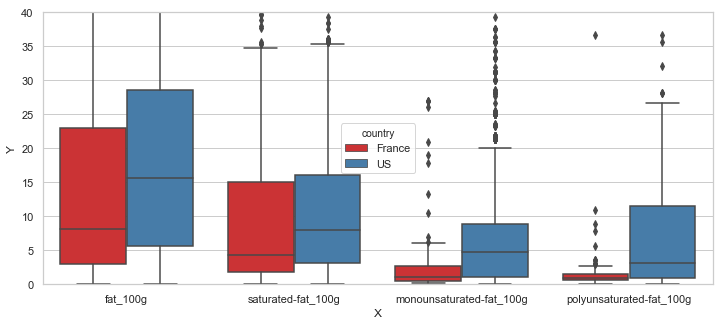

In [53]:
plt.figure(figsize=(12,5))
sns.set(style="whitegrid")
sns.boxplot(x="X",y ="Y", hue="country", data=data_boxplot, palette="Set1")
plt.ylim(0, 40)

With this plot we see some substantial differences between France and US.

#### Sugar and protein
Extract columns for sugar and protein for the dairy data:

In [54]:
france_interesting_nutri = france_dairy[['sugars_100g','proteins_100g']].astype(float).replace({0.0:np.nan})
us_interesting_nutri = us_dairy[['sugars_100g','proteins_100g']].astype(float).replace({0.0:np.nan})

Continue in the same way as for the fats:

In [55]:
data_boxplot_other_nutri = rearrange_for_boxplot(france_interesting_nutri,"France").append(rearrange_for_boxplot(us_interesting_nutri,"US"))

(0, 40)

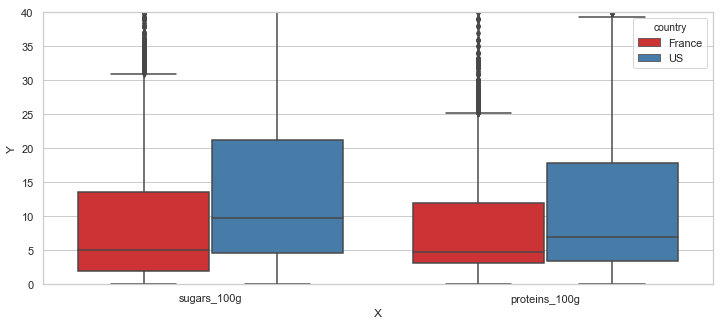

In [56]:
plt.figure(figsize=(12,5))
sns.set(style="whitegrid")
sns.boxplot(x="X",y ="Y", hue="country", data=data_boxplot_other_nutri, palette="Set1")
plt.ylim(0, 40)

To visualize the results of the fats, sugar and protein in the same plot for the data story we create a radar plot using the `pygal` library.

In [204]:
france_interesting_nutri = france_dairy[
    ['sugars_100g','proteins_100g','fat_100g','saturated-fat_100g','monounsaturated-fat_100g',
     'polyunsaturated-fat_100g','carbohydrates_100g']
].astype(float).replace({0.0:np.nan}).dropna().mean()
us_interesting_nutri = us_dairy[
    ['sugars_100g','proteins_100g','fat_100g','saturated-fat_100g','monounsaturated-fat_100g',
     'polyunsaturated-fat_100g','carbohydrates_100g']
].astype(float).replace({0.0:np.nan}).dropna().mean()

In [205]:
# Custom pygal style for the radar plot
radar_style = Style(
    background='transparent',
    font_family='googlefont:Muli',
    opacity='.6',
    opacity_hover='.9',
    label_font_size = 14,
    title_font_size = 17,
    legend_font_size = 15,
    colors=('#B22234', '#002395')
)

In [206]:
radar_chart = pygal.Radar(fill = True, style=radar_style)
radar_chart.title = 'Number of grams per 100g in dairy products'
radar_chart.x_labels = ['Sugars','Proteins','Fat','Saturated fat','Monounsaturated fat',
'Polyunsaturated fat','Carbohydrates']
radar_chart.add('US', us_interesting_nutri, formatter=lambda y: "{0:.2f}%".format(y))
radar_chart.add('France', france_interesting_nutri, formatter=lambda y: "{0:.2f}%".format(y))
radar_chart.render_to_file('dairy_nutri_radar_big.svg')

#### Minerals and vitamins

We also investigate minerals and vitamins in dairy products, but since these nutrients are in a much smaller quantity than the fats, protein or sugar we treat these separately and plot them in another plot (however using the same method).

In [207]:
tags = ['sodium_100g','calcium_100g']
tags2 = ['Sodium','Calcium']


france_interesting_small = france_dairy[tags].astype(float).replace({0.0:np.nan})
us_interesting_small = us_dairy[tags].astype(float).replace({0.0:np.nan})

To give more context to the plot we display the data as a fraction of the recommended daily intake. This is 2.3 mg for sodium and 0.8 mg for calcium.

In [208]:
daily_rec = [2.3,0.8]

radar_chart = pygal.Bar(fill = True, style=custom_style_france_first)
radar_chart.title = 'Nutrients per 100g in dairy products as a fraction of the recommended daily intake'
radar_chart.x_labels = tags2
radar_chart.add('France', (france_interesting_small/daily_rec).mean(), formatter=lambda y: "{0:.3f}".format(y))
radar_chart.add('US', (us_interesting_small/daily_rec).mean(), formatter=lambda y: "{0:.3f}".format(y))
radar_chart.render_to_file('dairy_nutri_small.svg')

## Category: Fats

Here we proceed similarily as we did for the dairy category, starting with defining the words we want to see in the food item data and specifying the words we do not want to see.

In [122]:
# These two regexps are here to make sure that there is either a white space or a word start/end before the end
# or the start of the words butter and oil.
butter = r'^(?:.*\s)?butter(?:\s.*)?$'
oil = r'^(?:.*\s)?oil(?:\s.*)?$'
fat_words = [
    butter, "fats", oil, "beurre", "lätta", "milda", "margarin", "huile", "coconut fat",
    "kerrygold", "lurpark", "plugra" 
]
non_fat_words = [
    "butter cups", "pop corn", "chicken", "popcorn", "potato", "toffee", "in oil", 
    "with olive oil", "with oil", "protein bar","olive oil &", "marinat", "in olive oil", 
    "bean", "snack", "ice cream", "cheese", "fromage", "a l'huile", "à l'huile", "caramel beurre", 
    "petits beurre", "granola", "frits", "fried", "au beurre", "croissant", "all butter", "yaourt", 
    "cookie", "chip", "sans huile", "sandwich", "soup", "pur beurre", "thon", "sauce", "chocolat", "chip", 
    "cookie", "biscuits", "cake", "seafood","chorizo", "joghurt","Foie gras","canard","Mayonnaise"
]

In [123]:
france_fats = select_entries(france, fat_words)
print("Fat related items in France before cleaning: " + str(france_fats.shape[0]))

france_fats = clean_categories(france_fats, non_fat_words, ['flour'])
print("Fat related items in France after cleaning: " + str(france_fats.shape[0]))

Fat related items in France before cleaning: 6218
Fat related items in France after cleaning: 3052


In [124]:
us_fats = select_entries(us, fat_words)
print("Fat related items in the US before cleaning: " + str(us_fats.shape[0]))

us_fats = clean_categories(us_fats, non_fat_words, ['flour'])
print("Fat related items in the US after cleaning: " + str(us_fats.shape[0]))

Fat related items in the US before cleaning: 6373
Fat related items in the US after cleaning: 3305


### Distribution in Fats
We not create a plot of the distribution of subcategory in the fats category, exactly analogously to what we did in the dairy category.

In [125]:
tags = np.matrix([['cooking spray', "cooking spray"], 
                 ["oliv", "oil"],
                 ["peanut", "peanut butter"],
                 ["oil", "oil"],
                 ["beurre", "butter"],
                 ["margarin", "margarin"],
                 ["butter", "butter"],
                 ["huile", "oil" ],
                 ["lätta", "margarin"],
                 ["becel", "margarin"],
                 ["original", "butter"],
                 ["öl", "oil"],
                ])

In [67]:
france_distri, _, _ = create_distribution(france_fats,tags)
france_distri_grouped = france_distri.groupby(['category']).sum().drop('tag', axis = 1)
france_distri_grouped['procent'] = france_distri_grouped['count'].apply(lambda x: x/france_distri_grouped['count'].sum())
france_distri_grouped['country'] = "France"

In [68]:
us_distri, _, _ = create_distribution(us_fats,tags)
us_distri_grouped = us_distri.groupby(['category']).sum().drop('tag', axis = 1)
us_distri_grouped['procent'] = us_distri_grouped['count'].apply(lambda x: x/us_distri_grouped['count'].sum() )
us_distri_grouped['country'] = "US"

In [69]:
# Same thing as for the dairy category, but we want to highlight the percentage of olive oil in the 
# oil sub category.
france_distri_full= [{'value': france_distri_grouped['procent'][0]},
                   {'value': france_distri_grouped['procent'][1]},
                   {'value': france_distri_grouped['procent'][2]},
                   {'value': france_distri_grouped['procent'][3], 'label': 'of which ' + "{0:.1f}".format(getSubProcent("oliv","oil",france_distri)) + '% is Olive oil'},
                   {'value': france_distri_grouped['procent'][4]},
                  ]
us_distri_full= [{'value': us_distri_grouped['procent'][0]},
                   {'value': us_distri_grouped['procent'][1]},
                   {'value': us_distri_grouped['procent'][2]},
                   {'value': us_distri_grouped['procent'][3], 'label': 'of which ' + "{0:.1f}".format(getSubProcent("oliv","oil",us_distri)) + '% is Olive oil'},
                   {'value': us_distri_grouped['procent'][4]},
                  ]

In [70]:
bar_chart_distri = pygal.Bar(style=custom_style_france_first)
bar_chart_distri.title = 'Distribution of subcategories within fats'
bar_chart_distri.x_labels = list(us_distri_grouped.T)
bar_chart_distri.add('France', france_distri_full, formatter=lambda y: "{0:.1f}%".format(y*100))
bar_chart_distri.add('US', us_distri_full, formatter=lambda y: "{0:.1f}%".format(y*100))
bar_chart_distri.render_to_file('fats_distribution.svg')  

### Investigation of nutrients in items classified as fats:

Here we are interested in the distributions of the different kinds (saturated fat, monounsaturated fat or polyunsaturated fat) of fats per 100g in each fat food item. We also want to take a look at the amount of sodium per 100g.

In [128]:
france_interesting_fats = france_fats[['saturated-fat_100g','monounsaturated-fat_100g',
'polyunsaturated-fat_100g']].astype(float).replace({0.0:np.nan})
us_interesting_fats = us_fats[['saturated-fat_100g','monounsaturated-fat_100g',
'polyunsaturated-fat_100g']].astype(float).replace({0.0:np.nan})

In [131]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Saturated fat in fat items'
box_chart.y_title = 'Saturated fat per 100g in g'
box_chart.add('France', france_interesting_fats['saturated-fat_100g'].dropna())
box_chart.add('US', us_interesting_fats['saturated-fat_100g'].dropna())
box_chart.render_to_file('fats_saturated-fat.svg')  

box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Polysaturated fat in fat items'
box_chart.y_title = 'Polysaturated fat per 100g in g'
box_chart.add('France', france_interesting_fats['polyunsaturated-fat_100g'].dropna())
box_chart.add('US', us_interesting_fats['polyunsaturated-fat_100g'].dropna())
box_chart.render_to_file('fats_polyunsaturated-fat.svg') 

box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Monosaturated fat in fat items'
box_chart.y_title = 'Monosaturated fat per 100g in g'
box_chart.add('France', france_interesting_fats['monounsaturated-fat_100g'].dropna())
box_chart.add('US', us_interesting_fats['monounsaturated-fat_100g'].dropna())
box_chart.render_to_file('fats_monounsaturated-fat.svg') 

We explore the data by creating boxplots, just like in the case of the dairy category.

In [73]:
data_boxplot = rearrange_for_boxplot(france_interesting_fats,"France").append(rearrange_for_boxplot(us_interesting_fats,"US"))

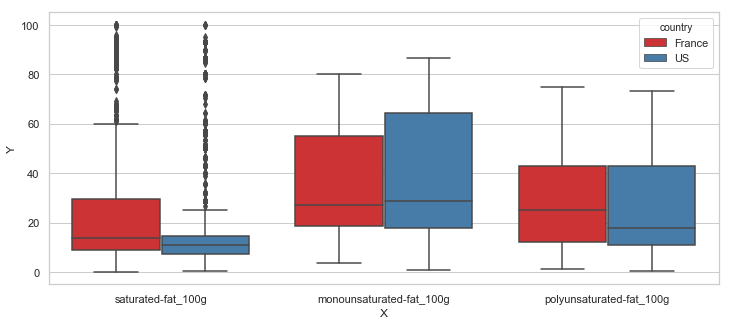

In [74]:
plt.figure(figsize=(12,5))
sns.set(style="whitegrid")
sns.boxplot(x="X",y ="Y", hue="country", data=data_boxplot, palette="Set1")

We notice some substantial differences here as well, and save the boxplots of the different kinds of fats using pygal:

We also plot a boxplot of the amount of sodium per 100g in each country:

In [76]:
france_fats_salt = france_fats[['sodium_100g']].astype(float).replace({0.0:np.nan})
us_fats_salt = us_fats[['sodium_100g']].astype(float).replace({0.0:np.nan})
data_boxplot_salt = rearrange_for_boxplot(france_fats_salt,"France").append(rearrange_for_boxplot(us_fats_salt,"US"))

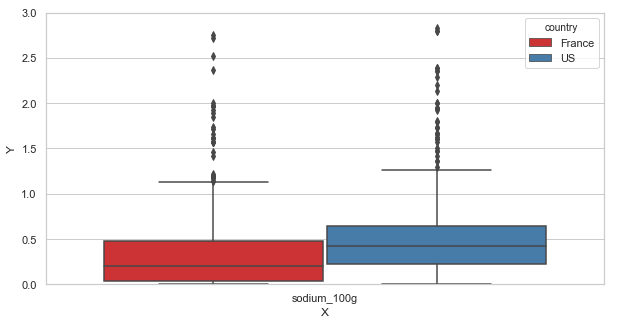

In [77]:
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")
plt.ylim(0, 3)
sns.boxplot(x="X",y ="Y", hue="country", data=data_boxplot_salt, 
            palette="Set1").set_title="Number of grams of sodium per 100g"

Here the difference is not very big between the countries.

## Category: bread

Read the data again without the conversion to object, to let pandas automatically infer types:

In [139]:
france = pd.read_csv(data_folder + 'france_data.csv')
usa = pd.read_csv(data_folder + 'us_data.csv')

### Filtering data

Here we find all the data which contain anything that can be considerer bread:

In [140]:
bread_words = ["bread", "pain", "toast", "whole grain", "grains entiers", "sourdough", "levain", "brioche",
               "baguette", "ciabatta", "focaccia", "multigrain", "pita", "rye", "wheat", "loaf", "crumb", 
               "crouton", "pumpernickel", "english muffin", "walkorn"]

In [141]:
non_bread_words = ["choco", "pour pain", "palets", "sablé", "cookie", "shortbread",
                   "galette", "Toastinade", "the noir", "seafood", "nugget", "sardines", "dairy", "dairi",
                   "pasta", "spaghetti", "farine de", "boissons", "Cordon bleu", "biscuit", "meat",
                   "chicken", "cheese", "chip", "fromage", "beverage", "wheat flake", "cereal", "bread mix",
                   "lasagn", "breading", "wheat berries", "toaster pastry", "toasted", "cracker",
                   "soy nut", "pâtes"]
not_allowed_ingredients = ["pasta"]

In [142]:
breads_france = select_entries(france, bread_words)
breads_usa = select_entries(usa, bread_words)

breads_france_before = breads_france.shape[0]
breads_usa_before = breads_usa.shape[0]

breads_france = clean_categories(breads_france, non_bread_words, not_allowed_ingredients)
breads_usa = clean_categories(breads_usa, non_bread_words, not_allowed_ingredients)

print("Bread items in France before cleaning: {}".format(breads_france_before))
print("Bread items in France after cleaning: {}".format(breads_france.shape[0]))
print("")
print("Bread items in USA before cleaning: {}".format(breads_usa_before))
print("Bread items in USA after cleaning: {}".format(breads_usa.shape[0]))

Bread items in France before cleaning: 6171
Bread items in France after cleaning: 3107

Bread items in USA before cleaning: 8802
Bread items in USA after cleaning: 5404


Here we see that in our data there is a higher amount of bread-related items in the US compared to France. One reason for this could be that buying bread at a bakery is much more common in France compared to the US, resulting in that the demand for bread as a product in stores is not as high.

### Plotting distributions of nutrients

In [82]:
france_interesting_cols = breads_france[['sugars_100g', 'fat_100g', 'fiber_100g', 'carbohydrates_100g']].astype(float).replace({0.0:np.nan})
usa_interesting_cols = breads_usa[['sugars_100g', 'fat_100g', 'fiber_100g', 'carbohydrates_100g']].astype(float).replace({0.0:np.nan})

In [83]:
data_boxplot = rearrange_for_boxplot(france_interesting_cols,"France").append(
    rearrange_for_boxplot(usa_interesting_cols,"US"))

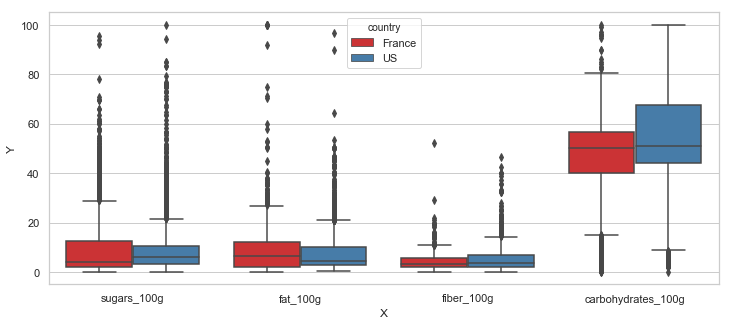

In [84]:
plt.figure(figsize=(12,5))
sns.set(style="whitegrid")
sns.boxplot(x="X",y ="Y", hue="country", data=data_boxplot, palette="Set1")

With the boxplot we observe that the majority of the bread items have around 2-15 grams of sugar per 100g, which makes sense. Based on this plot it seems like the sugar levels are little bit lower for the bread in France compared to in the US, but the variance is bigger in France.

The big difference is that carbohydrates are in general higher per 100g in the US.

We create boxplots for the data story for the different nutriments:

In [113]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Energy in bread items'
box_chart.y_title = 'Energy per 100g in kJ'

box_chart.add('France', breads_france['energy_100g'].dropna())
box_chart.add('US', breads_usa['energy_100g'].dropna())
box_chart.render_to_file('breads_energy.svg')

In [114]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Carbohydrate in bread items'
box_chart.y_title = 'Carbohydrates per 100g in g'

box_chart.add('France', breads_france['carbohydrates_100g'].dropna())
box_chart.add('US', breads_usa['carbohydrates_100g'].dropna())
box_chart.render_to_file('breads_carbs.svg')

In [115]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Fiber in bread items'
box_chart.y_title = 'Fiber per 100g in g'

box_chart.add('France', np.log(breads_france['fiber_100g'] + 1).dropna())
# Transform into log(x + 1) to be able to plot logarithmic scale with the zero values
box_chart.add('US', np.log(breads_usa['fiber_100g'] + 1).dropna())
box_chart.y_labels = np.log((np.array([0, 1, 5, 10, 50, 100]) + 1)).tolist()
# Transform the y-axis to exp(y) - 1 to match the x-axis
box_chart.value_formatter = lambda y: "{:10.2f}".format(math.exp(float(y)) - 1)
box_chart.render_to_file('breads_fiber.svg')

In [116]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Sugar in bread items'
box_chart.y_title = 'Sugar per 100g in g'

box_chart.add('France', breads_france['sugars_100g'].dropna())
box_chart.add('US', breads_usa['sugars_100g'].dropna())
box_chart.render_to_file('breads_sugars.svg')

In [117]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Fat in bread items'
box_chart.y_title = 'Fat per 100g in g'

box_chart.add('France', breads_france['fat_100g'].dropna())
box_chart.add('US', breads_usa['fat_100g'].dropna())
box_chart.render_to_file('breads_fats.svg')

## Category: meat, poultry, fish and seafood

Here we find all the data which contain anything that can be considerer meat, poultry, fish and seafood:

In [13]:
allowed_words = ["meat", "poultry", "fish", "seafood", "chicken", "pork", "cow", "veal", "veau", "shrimp",
               "beef", "steak", "turkey", "duck", "foie gras", "agneau", "porc", "cheval", "viande",
                "rib", "loin", "boeuf", "bœuf", "vache", "poule", "poisson", "crayfish", "lobster", "saumon",
                "salmon", "thon", "tuna", "sardine", "charcuterie"]

In [14]:
not_allowed_words = ["cheese", "sauce", "sandwich", "pizza", "fromage", "frites", "ravioli", "dairi", "dairy", 
                     "soup", "yaourt", "nugget", "gravy", "cracker", "pie", "broth", "bouillon", "quiche",
                     "chicken dinner", "salad", "base", "dumpling", "chowder", "panini", "bread", "popcorn",
                     "seasoning mix", "creole", "beefless", "tagliatelle", "terrine", "taboule", "risotto",
                     "rice", "riz", "creme", "crème", "boulghour", "mousse", "fisherman", "beverage", "ice cream",
                     "aceituna", "haribo"]
not_allowed_ingredients = ["pasta", "légume", "vegetable"]

In [83]:
meats_france = select_entries(france, allowed_words)
meats_usa = select_entries(usa, allowed_words)

meats_france_before = meats_france.shape[0]
meats_usa_before = meats_usa.shape[0]


meats_france = clean_categories(meats_france, not_allowed_words, not_allowed_ingredients)
meats_usa = clean_categories(meats_usa, not_allowed_words, not_allowed_ingredients)

print("Meat, poultry, fish and seafood items in France before cleaning: {}".format(meats_france_before))
print("Meat, poultry, fish and seafood items in France after cleaning: {}".format(meats_france.shape[0]))
print("")
print("Meat, poultry, fish and seafood items in USA before cleaning: {}".format(meats_usa_before))
print("Meat, poultry, fish and seafood items in USA after cleaning: {}".format(meats_usa.shape[0]))

Meat, poultry, fish and seafood items in France before cleaning: 18327
Meat, poultry, fish and seafood items in France after cleaning: 12544

Meat, poultry, fish and seafood items in USA before cleaning: 14011
Meat, poultry, fish and seafood items in USA after cleaning: 8558


### Plotting distribution of nutrients

In [91]:
france_interesting_cols = meats_france[['proteins_100g', 'fat_100g', 'fiber_100g', 'carbohydrates_100g', 'sugars_100g']].astype(float).replace({0.0:np.nan})
usa_interesting_cols = meats_usa[['proteins_100g', 'fat_100g', 'fiber_100g', 'carbohydrates_100g', 'sugars_100g']].astype(float).replace({0.0:np.nan})

In [92]:
data_boxplot = rearrange_for_boxplot(france_interesting_cols,"France").append(
    rearrange_for_boxplot(usa_interesting_cols,"US"))

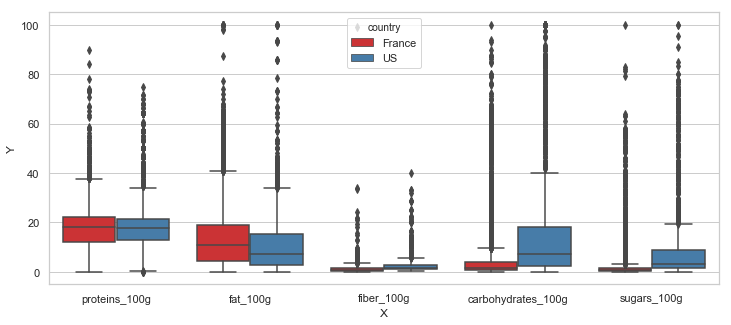

In [93]:
plt.figure(figsize=(12,5))
sns.set(style="whitegrid")
sns.boxplot(x="X",y ="Y", hue="country", data=data_boxplot, palette="Set1")

Here we see that when it comes to protein levels the food items in the US and in France are fairly equal. As for the fats it seems to be the case that france has more fat in the food items in this category than the US. Let's investigate this by looking at the meat items in the France data with fat between 50g and 80g per 100g:

In [54]:
high_fat = meats_france[meats_france['fat_100g'] > 50]
high_fat = high_fat[high_fat['fat_100g'] < 90]['product_name']
num_high_fat = high_fat.shape[0]
num_foie_gras = high_fat[high_fat.str.contains("foie gras", flags=re.IGNORECASE)].shape[0]
print("Number of items between 50g and 80g fat per 100g: " + str(num_high_fat))
print("Number of foie gras items between 50g and 80g fat per 100g: " + str(num_foie_gras))
print("Among the food items in france which have between 50g and 80g fat per 100g, " 
      + "{:.2f}".format(100*num_foie_gras/num_high_fat) + "% are foie gras.")

Number of items between 50g and 80g fat per 100g: 380
Number of foie gras items between 50g and 80g fat per 100g: 292
Among the food items in france which have between 50g and 80g fat per 100g, 76.84% are foie gras.


We see that there is almost exclusively variants of foie gras there, which might explain the big difference, as this dish is not as popular in the US as it is in France.

The big difference between the two countries however can be seen in the amount of carbohydrates. The US has much more than France.
What could be the reason for this? An hypothesis is that for the products in the US, more things containing a lot of calories are often added to the food items, for example sauces, or that the items are fried. 

Finally, let's save the boxplots for the different nutriments for this category, removing two outliers and using a log scale for better visibility for the sugar and carbohydrate plots:

In [87]:
meats_usa = meats_usa[meats_usa['energy_100g'] < 8000]  # remove outliers
meats_france = meats_france[meats_france['energy_100g'] < 8000]

In [89]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Energy in meat items'
box_chart.y_title = 'Energy per 100g in kJ'

box_chart.add('France', meats_france['energy_100g'].dropna())
box_chart.add('US', meats_usa['energy_100g'].dropna())
box_chart.render_to_file('meats_energy.svg')

In [90]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Sugars in meat items'

box_chart.add('France', np.log(meats_france['sugars_100g'] + 1).dropna())
# Transform into log(x + 1) to be able to plot logarithmic scale with the zero values
box_chart.add('US', np.log(meats_usa['sugars_100g'] + 1).dropna())
box_chart.y_labels = np.log((np.array([0, 1, 5, 10, 50, 100]) + 1)).tolist()
# Transform the y-axis to exp(y) - 1 to match the x-axis
box_chart.value_formatter = lambda y: "{:10.2f}".format(math.exp(float(y)) - 1)
box_chart.render_to_file('meats_sugars.svg')


In [91]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Carbohydrates in meat items'
box_chart.y_title = 'Carbohydrates per 100g in g'

box_chart.add('France', np.log(meats_france['carbohydrates_100g'] + 1).dropna())
# Transform into log(x + 1) to be able to plot logarithmic scale with the zero values
box_chart.add('US', np.log(meats_usa['carbohydrates_100g'] + 1).dropna())
box_chart.y_labels = np.log((np.array([0, 1, 5, 10, 50, 100]) + 1)).tolist()
# Transform the y-axis to exp(y) - 1 to match the x-axis
box_chart.value_formatter = lambda y: "{:10.2f}".format(math.exp(float(y)) - 1)
box_chart.render_to_file('meats_carbs.svg')

In [92]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Fats in meat items'
box_chart.y_title = 'Fat per 100g in g'

box_chart.add('France', meats_france['fat_100g'].dropna())
box_chart.add('US', meats_usa['fat_100g'].dropna())
box_chart.render_to_file('meats_fats.svg')

In [93]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Protein in meat items'
box_chart.y_title = 'Protein per 100g in g'

box_chart.add('France', meats_france['proteins_100g'].dropna())
box_chart.add('US', meats_usa['proteins_100g'].dropna())
box_chart.render_to_file('meats_proteins.svg')

## Category: Snacks

First we select all rows that is associated with snacks. Then we clean out the category to smaller categories.

In [209]:
snacks = [
    'snack', 'bar', 'ice cream', 'chips', 'popcorn', 'cake', 'cookie', 'choco', 'sugary', 'salty'
]

In [210]:
snacks_france = select_entries(france, snacks)
snacks_usa = select_entries(usa, snacks)

In [211]:
print("There are %d entries that are classified as snacks for France." % len(snacks_france))
print("There are %d entries that are classified as snacks for USA." % len(snacks_usa))

There are 22364 entries that are classified as snacks for France.
There are 31544 entries that are classified as snacks for USA.


### Sugary snacks

We create one category called `sugary_snacks`. This category will have all snacks defined as sugary and not salty. Then we will devide this category in smaller categories. We also create a dataframe to be used when calculating the distribution.

In [212]:
sugary = [
    'choco', 'coco', 'cookie', 'candy', 'candies', 'candi', 'bonbon', 'fudge', 'caramel', 'bar', 'nougat',
    'sugar', 'sucr', 'cake', 'gâteux', 'ice cream'
]

In [213]:
sugary_snacks_france = select_entries(snacks_france, sugary)
sugary_snacks_usa = select_entries(snacks_usa, sugary)

In [214]:
not_sugary_snacks = [
    'popcorn', 'chips', 'patate', 'potato', 'Snacks salés'
]
not_sugary_snacks_ingredients = ['patate', 'salé', 'salt']

In [215]:
sugary_snacks_france = clean_categories(sugary_snacks_france, not_sugary_snacks, not_sugary_snacks_ingredients)
sugary_snacks_usa = clean_categories(sugary_snacks_usa, not_sugary_snacks, not_sugary_snacks_ingredients)

In [216]:
print("Number of sugary snacks in France: %d" % len(sugary_snacks_france))
print("Number of sugary snacks in USA: %d" % len(sugary_snacks_usa))

Number of sugary snacks in France: 18164
Number of sugary snacks in USA: 11177


In [217]:
sugary_snacks_distr = pd.DataFrame(columns = ['category', 'count', 'country'])

The category contains a lot of rows. We will divide the category into sub-categories `chocolates`, `bars`, `candy` and `cookies`. We start with chocolates.

In [218]:
chocolate = [
    'chocolate', 'chocolat', 'choco', 'cacao', 'coco'
]

In [219]:
chocolates_france = select_entries(sugary_snacks_france, chocolate)
chocolates_usa = select_entries(sugary_snacks_usa, chocolate)

Looking at the frames we do not find any values that clearly should not be there and therefore we skip cleaning the category.

In [220]:
print("Sugary snacks that are made with chocolate in France: %d" % len(chocolates_france))
print("Sugary snacks that are made with chocolate in USA: %d" % len(chocolates_usa))

Sugary snacks that are made with chocolate in France: 10613
Sugary snacks that are made with chocolate in USA: 5742


In [221]:
sugary_snacks_distr = sugary_snacks_distr.append(
    pd.DataFrame([['Chocolates', len(chocolates_france), 'France']], columns=['category', 'count', 'country'])
)
sugary_snacks_distr = sugary_snacks_distr.append(
    pd.DataFrame([['Chocolates', len(chocolates_usa), 'USA']], columns=['category', 'count', 'country'])
)

We then move forward to `bars`.

In [222]:
bars = ['bar', 'bars']

In [223]:
bars_france = select_entries(sugary_snacks_france, bars)
bars_usa = select_entries(sugary_snacks_usa, bars)

We look at the dataframes to decide what should not be classified as bars and then remove based on words that are not associated with bars. Note that we keep all bars that are made with chocolate even though these are also in the `chocolates` category.

In [224]:
not_bars = ['barbecue', 'rhubarb', 'barbe', 'baratte', 'barley']

In [225]:
bars_france = clean_categories(bars_france, not_bars)
bars_usa = clean_categories(bars_usa, not_bars)

In [226]:
print('Number of bars in France: %d' % len(bars_france))
print('Number of bars in the USA: %d' % len(bars_usa))

Number of bars in France: 2265
Number of bars in the USA: 2261


In [227]:
sugary_snacks_distr = sugary_snacks_distr.append(
    pd.DataFrame([['Bars', len(bars_france), 'France']], columns=['category', 'count', 'country'])
)
sugary_snacks_distr = sugary_snacks_distr.append(
    pd.DataFrame([['Bars', len(bars_usa), 'USA']], columns=['category', 'count', 'country'])
)

Next up is `candy`.

In [228]:
candy = [
    'candy', 'candies', 'bonbon', 'candi', 'confectioneries', 'pastilles', 'mints', 'caramels', 'gummies',
    'lollipop'
]

In [229]:
candy_france = select_entries(sugary_snacks_france, candy)
candy_usa = select_entries(sugary_snacks_usa, candy)

Looking at the frames no values seem to be out of place.

In [230]:
print("Rows classified as candy in France: %d" % len(candy_france))
print("Rows classified as candy in the USA: %d" % len(candy_usa))

Rows classified as candy in France: 1943
Rows classified as candy in the USA: 419


In [231]:
sugary_snacks_distr = sugary_snacks_distr.append(
    pd.DataFrame([['Candy', len(candy_france), 'France']], columns=['category', 'count', 'country'])
)
sugary_snacks_distr = sugary_snacks_distr.append(
    pd.DataFrame([['Candy', len(candy_usa), 'USA']], columns=['category', 'count', 'country'])
)

Lastly we create the category `cookies`.

In [232]:
cookies_france = select_entries(sugary_snacks_france, ['cookie', 'biscuit'])
cookies_usa = select_entries(sugary_snacks_usa, ['cookie', 'biscuit'])

In [233]:
not_cookies = [
    'brownie', 'muffin', 'candy', 'candies', 'candi', 'kit kat', 'tourteaux fromagés', 'gaufres', 'gâteau à la',
    'cakes ', 'fondants ', 'pancake', 'ice cream'
]

In [234]:
cookies_france = clean_categories(cookies_france, not_cookies)
cookies_usa = clean_categories(cookies_usa, not_cookies)

In [235]:
print("Number of cookies in France: %d" % len(cookies_france))
print("Number of cookies in USA: %d" % len(cookies_usa))

Number of cookies in France: 4343
Number of cookies in USA: 1822


In [236]:
sugary_snacks_distr = sugary_snacks_distr.append(
    pd.DataFrame([['Cookies', len(cookies_france), 'France']], columns=['category', 'count', 'country'])
)
sugary_snacks_distr = sugary_snacks_distr.append(
    pd.DataFrame([['Cookies', len(cookies_usa), 'USA']], columns=['category', 'count', 'country'])
)

### Salty snacks

The second big category will be `salty_snacks`. We will then divide this category into smaller categories.

In [237]:
salty = [
    'salt', 'salé', 'chips', 'popcorn', 'sodium', 'crisps'
]

In [238]:
salty_snacks_france = select_entries(snacks_france, salty)
salty_snacks_usa = select_entries(snacks_usa, salty)

In [239]:
not_salty = [
    'sucr', 'sugar', 'cake', 'caramel'
]

In [240]:
salty_snacks_france = clean_categories(salty_snacks_france, not_salty)
salty_snacks_usa = clean_categories(salty_snacks_usa, not_salty)

In [241]:
print("Number of salty snacks in France: %d" % len(salty_snacks_france))
print("Number of salty snacks in USA: %d" % len(salty_snacks_usa))

Number of salty snacks in France: 2682
Number of salty snacks in USA: 5692


In [242]:
salty_snacks_distr = pd.DataFrame(columns = ['category', 'count', 'country'])

We divide the category into `chips` and `popcorn`, starting out with `chips`.

In [243]:
chips_france = select_entries(salty_snacks_france, ['chips', 'crisps'])
chips_usa = select_entries(salty_snacks_usa, ['chips', 'crisps'])

In [244]:
print("Number of chips in France: %d" % len(chips_france))
print("Number of chips in USA: %d" % len(chips_usa))

Number of chips in France: 1563
Number of chips in USA: 4102


In [245]:
salty_snacks_distr = salty_snacks_distr.append(
    pd.DataFrame([['Chips', len(chips_france), 'France']], columns=['category', 'count', 'country'])
)
salty_snacks_distr = salty_snacks_distr.append(
    pd.DataFrame([['Chips', len(chips_usa), 'USA']], columns=['category', 'count', 'country'])
)

We then proceed to `popcorn`.

In [246]:
popcorn_france = select_entries(salty_snacks_france, ['popcorn'])
popcorn_usa = select_entries(salty_snacks_usa, ['popcorn'])

In [247]:
print("Number of popcorn in France: %d" % len(popcorn_france))
print("Number of popcorn in USA: %d" % len(popcorn_usa))

Number of popcorn in France: 112
Number of popcorn in USA: 1110


In [248]:
salty_snacks_distr = salty_snacks_distr.append(
    pd.DataFrame([['Popcorn', len(popcorn_france), 'France']], columns=['category', 'count', 'country'])
)
salty_snacks_distr = salty_snacks_distr.append(
    pd.DataFrame([['Popcorn', len(popcorn_usa), 'USA']], columns=['category', 'count', 'country'])
)

The category `biscuits` represent salty crackers and biscuits.

In [249]:
crackers_france = select_entries(salty_snacks_france, ['crackers', 'biscuit'])
crackers_usa = select_entries(salty_snacks_usa, ['crackers', 'biscuit'])

In [250]:
print("Number of biscuits in France: %d" % len(crackers_france))
print("Number of biscuits in USA: %d" % len(crackers_usa))

Number of biscuits in France: 518
Number of biscuits in USA: 78


In [251]:
salty_snacks_distr = salty_snacks_distr.append(
    pd.DataFrame([['Biscuits', len(crackers_france), 'France']], columns=['category', 'count', 'country'])
)
salty_snacks_distr = salty_snacks_distr.append(
    pd.DataFrame([['Biscuits', len(crackers_usa), 'USA']], columns=['category', 'count', 'country'])
)

Last subcategory is `nuts_and_seeds`.

In [252]:
nuts_france = select_entries(salty_snacks_france, ['nut', 'almond'])
nuts_usa = select_entries(salty_snacks_usa, ['nut', 'almond'])

In [253]:
print("Number of nuts and seeds in France: %d" % len(nuts_france))
print("Number of nuts and sees in USA: %d" % len(nuts_usa))

Number of nuts and seeds in France: 139
Number of nuts and sees in USA: 318


In [254]:
salty_snacks_distr = salty_snacks_distr.append(
    pd.DataFrame([['Nuts and seeds', len(nuts_france), 'France']], columns=['category', 'count', 'country'])
)
salty_snacks_distr = salty_snacks_distr.append(
    pd.DataFrame([['Nuts and seeds', len(nuts_usa), 'USA']], columns=['category', 'count', 'country'])
)

### Distribution of snacks

We start by creating dataframes for both sugary and salty snacks.

In [255]:
sugary_snacks_distr['procent'] = sugary_snacks_distr['count'].apply(
    lambda x: x/sugary_snacks_distr['count'].sum()
)

In [256]:
salty_snacks_distr['procent'] = salty_snacks_distr['count'].apply(
    lambda x: x/salty_snacks_distr['count'].sum()
)

In [257]:
salty_snacks_distr

,category,count,country,procent
0,Chips,1563,France,0.196851
0,Chips,4102,USA,0.516625
0,Popcorn,112,France,0.014106
0,Popcorn,1110,USA,0.139798
0,Biscuits,518,France,0.065239
0,Biscuits,78,USA,0.009824
0,Nuts and seeds,139,France,0.017506
0,Nuts and seeds,318,USA,0.040050


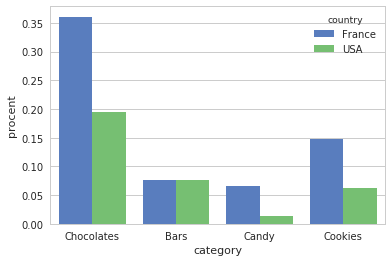

In [258]:
sns.set(style="whitegrid")

g = sns.barplot(x='category', y="procent", hue="country", data=sugary_snacks_distr, palette="muted")

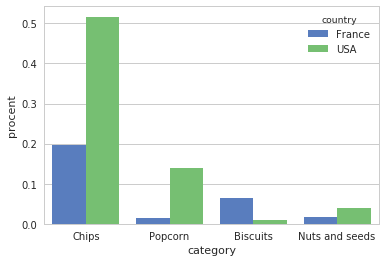

In [259]:
sns.set(style="whitegrid")

g = sns.barplot(x='category', y="procent", hue="country", data=salty_snacks_distr, palette="muted")

In [260]:
sugary_france_distr = sugary_snacks_distr[sugary_snacks_distr.country == 'France']
sugary_usa_distr = sugary_snacks_distr[sugary_snacks_distr.country == 'USA']
salty_france_distr = salty_snacks_distr[salty_snacks_distr.country == 'France']
salty_usa_distr = salty_snacks_distr[salty_snacks_distr.country == 'USA']

In [261]:
bar_chart_distri = pygal.Bar(style=custom_style_france_first)
bar_chart_distri.x_title = 'Categories'
bar_chart_distri.y_title = 'Percent of total sugary snacks'
bar_chart_distri.x_labels = list(sugary_snacks_distr.category.unique())
bar_chart_distri.y_labels = [
    {'label': '0%', 'value': 0.0},
    {'label': '10%', 'value': 0.1},
    {'label': '20%', 'value': 0.2},
    {'label': '30%', 'value': 0.3},
    {'label': '40%', 'value': 0.4},
    {'label': '50%', 'value': 0.5},
    {'label': '60%', 'value': 0.6}
]
bar_chart_distri.add('France', sugary_france_distr['procent'], formatter=lambda y: "{0:.1f}%".format(y*100))
bar_chart_distri.add('USA', sugary_usa_distr['procent'], formatter=lambda y: "{0:.1f}%".format(y*100))
bar_chart_distri.render_to_file('sugary_snacks_distribution.svg')  

In [262]:
bar_chart_distri2 = pygal.Bar(style=custom_style_france_first)
bar_chart_distri2.x_title = 'Categories'
bar_chart_distri2.y_title = 'Percent of total salty snacks'
bar_chart_distri2.x_labels = list(salty_snacks_distr.category.unique())
bar_chart_distri2.y_labels = [
    {'label': '0%', 'value': 0.0},
    {'label': '10%', 'value': 0.1},
    {'label': '20%', 'value': 0.2},
    {'label': '30%', 'value': 0.3},
    {'label': '40%', 'value': 0.4},
    {'label': '50%', 'value': 0.5},
    {'label': '60%', 'value': 0.6}
]
bar_chart_distri2.add('France', salty_france_distr['procent'], formatter=lambda y: "{0:.1f}%".format(y*100))
bar_chart_distri2.add('USA', salty_usa_distr['procent'], formatter=lambda y: "{0:.1f}%".format(y*100))
bar_chart_distri2.render_to_file('salty_snacks_distribution.svg')  

### Nutrition

In [263]:
sugary_snacks_france = sugary_snacks_france.reset_index(drop=True)
salty_snacks_france = salty_snacks_france.reset_index(drop=True)

sugary_snacks_usa = sugary_snacks_usa.reset_index(drop=True)
salty_snacks_usa = salty_snacks_usa.reset_index(drop=True)

We'll start by looking at the sugar content in `sugary_snacks`.

In [264]:
france_nutrition = sugary_snacks_france[['sugars_100g','energy_100g',
'carbohydrates_100g', 'serving_quantity']].astype(float).replace({0.0:np.nan})
usa_nutrition = sugary_snacks_usa[['sugars_100g','energy_100g',
'carbohydrates_100g', 'serving_quantity']].astype(float).replace({0.0:np.nan})

In [265]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Sugar per 100g'
box_chart.add('France', france_nutrition['sugars_100g'].dropna())
box_chart.add('USA', usa_nutrition['sugars_100g'].dropna())
box_chart.render_to_file('snacks_sugars.svg')  

In [266]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Energy per 100g'
box_chart.add('France', france_nutrition['energy_100g'].dropna())
box_chart.add('USA', usa_nutrition['energy_100g'].dropna())
box_chart.render_to_file('snacks_sugary_energy.svg')  

In [267]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Carbohydrates per 100g'
box_chart.add('France', france_nutrition['carbohydrates_100g'].dropna())
box_chart.add('USA', usa_nutrition['carbohydrates_100g'].dropna())
box_chart.render_to_file('snacks_sugary_carbohydrates.svg')

In [268]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Serving quantity'
box_chart.add('France', france_nutrition['serving_quantity'].dropna())
box_chart.add('USA', usa_nutrition['serving_quantity'].dropna())
box_chart.render_to_file('snacks_sugary_servings.svg')

The result is hard to see because we have outliers. We will remove these for this visualisation to see the distribution clearly.

In [269]:
france_nutrition_cleaned = france_nutrition.copy()
usa_nutrition_cleaned = usa_nutrition.copy()

In [270]:
mask_max_f = france_nutrition_cleaned.energy_100g > 3000
france_nutrition_cleaned.loc[mask_max_f, 'energy_100g'] = np.nan
mask_max_u = usa_nutrition_cleaned.energy_100g > 3000
usa_nutrition_cleaned.loc[mask_max_u, 'energy_100g'] = np.nan

Removing outliers gives a plot that more clearly shows the distribution in the countries.

In [271]:
box_chart = pygal.Box(style=custom_style_france_first)
box_chart.title = 'Energy per 100g'
box_chart.add('France', france_nutrition_cleaned['energy_100g'].dropna())
box_chart.add('USA', usa_nutrition_cleaned['energy_100g'].dropna())
box_chart.render_to_file('snacks_sugary_energy_cleaned.svg') 

We try another way, by using a histogram instead, removing the outliers.

In [272]:
# Calculate bin size for 50 bins
bin_size_france = france_nutrition_cleaned.energy_100g.dropna().max()/50

# Make bins
bins_france = np.zeros(51)
for i in range(51):
    bins_france[i] = i*bin_size_france
    
values_bins_france = pd.cut(france_nutrition_cleaned.energy_100g.dropna(), bins_france)

# Format bins for pygal
bins_histo_france = list(zip(values_bins_france.value_counts().sort_index(), bins_france[:-1], bins_france[1:]))

In [273]:
hist_energy_france = pygal.Histogram(style=custom_style_france_first)
hist_energy_france.title = 'Distribution of energy per 100g'
hist_energy_france.x_title = 'Energy per 100g in kJ'
hist_energy_france.y_title = 'Number of products'
hist_energy_france.add('France', bins_histo_france)
hist_energy_france.render_to_file('energy_sugary_snacks_france_hist.svg') 

In [274]:
# Calculate bin size for 50 bins
bin_size_usa = usa_nutrition_cleaned.energy_100g.dropna().max()/50

# Make bins
bins_usa = np.zeros(51)
for i in range(51):
    bins_usa[i] = i*bin_size_usa
    
values_bins_usa = pd.cut(usa_nutrition_cleaned.energy_100g.dropna(), bins_usa)

# Format bins for pygal
bins_histo_usa = list(zip(values_bins_usa.value_counts().sort_index(), bins_usa[:-1], bins_usa[1:]))

In [279]:
hist_energy_usa = pygal.Histogram(style=custom_style_usa_first)
hist_energy_usa.title = 'Distribution of energy per 100g'
hist_energy_usa.x_title = 'Energy per 100g in kJ'
hist_energy_usa.y_title = 'Number of products'
hist_energy_usa.add('USA', bins_histo_usa)
hist_energy_usa.render_to_file('energy_sugary_snacks_usa_hist.svg') 

Start of by cleaning `salty_snacks`.

In [280]:
france_salty_nutrition = salty_snacks_france[['sodium_100g', 'fat_100g', 'saturated-fat_100g', 'energy_100g',
'carbohydrates_100g', 'serving_quantity']].astype(float).replace({0.0:np.nan})
usa_salty_nutrition = salty_snacks_usa[['sodium_100g', 'fat_100g', 'saturated-fat_100g', 'energy_100g',
'carbohydrates_100g', 'serving_quantity']].astype(float).replace({0.0:np.nan})

france_salty_nutrition_cleaned = france_salty_nutrition.copy()
usa_salty_nutrition_cleaned = usa_salty_nutrition.copy()

mask_max_f = france_salty_nutrition_cleaned.energy_100g > 3000
france_salty_nutrition_cleaned.loc[mask_max_f, 'energy_100g'] = np.nan
mask_max_u = usa_salty_nutrition_cleaned.energy_100g > 3000
usa_salty_nutrition_cleaned.loc[mask_max_u, 'energy_100g'] = np.nan

Wecreate box plots for all nutriments except `energy_100g`.

In [281]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Sodium in salty snacks'
box_chart.y_title = 'Sodium per 100g (g)'

box_chart.add('France', np.log(france_salty_nutrition['sodium_100g'] + 1).dropna())
# Transform into log(x + 1) to be able to plot logarithmic scale with the zero values
box_chart.add('USA', np.log(usa_salty_nutrition['sodium_100g'] + 1).dropna())
box_chart.y_labels = np.log((np.array([0, 1, 5, 10, 50, 100]) + 1)).tolist()
# Transform the y-axis to exp(y) - 1 to match the x-axis
box_chart.value_formatter = lambda y: "{:10.2f}".format(math.exp(float(y)) - 1)
box_chart.render_to_file('snacks_salty_sodium.svg') 

In [282]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Fats in salty snacks'
box_chart.y_title = 'Fat per 100g (g)'

box_chart.add('France', france_salty_nutrition['fat_100g'].dropna())
box_chart.add('USA', usa_salty_nutrition['fat_100g'].dropna())
box_chart.render_to_file('snacks_salty_fats.svg')  

In [283]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Saturated fat in salty snacks'
box_chart.y_title = 'Saturated fat per 100g (g)'

box_chart.add('France', np.log(france_salty_nutrition['saturated-fat_100g'] + 1).dropna())
# Transform into log(x + 1) to be able to plot logarithmic scale with the zero values
box_chart.add('USA', np.log(usa_salty_nutrition['saturated-fat_100g'] + 1).dropna())
box_chart.y_labels = np.log((np.array([0, 1, 5, 10, 50, 100]) + 1)).tolist()
# Transform the y-axis to exp(y) - 1 to match the x-axis
box_chart.value_formatter = lambda y: "{:10.2f}".format(math.exp(float(y)) - 1)
box_chart.render_to_file('snacks_salty_saturated_fat.svg')  

In [284]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Carbohydrates in salty snacks'
box_chart.y_title = 'Carbohydrates per 100g (g)'

box_chart.add('France', france_salty_nutrition['carbohydrates_100g'].dropna())
box_chart.add('USA', usa_salty_nutrition['carbohydrates_100g'].dropna())
box_chart.render_to_file('snacks_salty_carbohydrates.svg')  

In [285]:
box_chart = pygal.Box(box_mode="tukey", style=custom_style_france_first)
box_chart.title = 'Serving quantity for salty snacks'
box_chart.y_title = 'Serving quantity (g)'

box_chart.add('France', np.log(france_salty_nutrition['serving_quantity'] + 1).dropna())
# Transform into log(x + 1) to be able to plot logarithmic scale with the zero values
box_chart.add('USA', np.log(usa_salty_nutrition['serving_quantity'] + 1).dropna())
box_chart.y_labels = np.log((np.array([0, 1, 5, 10, 20, 25, 30, 40]) + 1)).tolist()
# Transform the y-axis to exp(y) - 1 to match the x-axis
box_chart.value_formatter = lambda y: "{:10.2f}".format(math.exp(float(y)) - 1)
box_chart.render_to_file('snacks_salty_servings.svg')  

In [286]:
# Calculate bin size for 50 bins
bin_size_france = france_salty_nutrition_cleaned.energy_100g.dropna().max()/50

# Make bins
bins_france = np.zeros(51)
for i in range(51):
    bins_france[i] = i*bin_size_france
    
values_bins_france = pd.cut(france_salty_nutrition_cleaned.energy_100g.dropna(), bins_france)

# Format bins for pygal
bins_histo_france = list(zip(values_bins_france.value_counts().sort_index(), bins_france[:-1], bins_france[1:]))

In [287]:
hist_energy_france = pygal.Histogram(style=custom_style_france_first)
hist_energy_france.title = 'Distribution of energy per 100g'
hist_energy_france.x_title = 'Energy per 100g in kJ'
hist_energy_france.y_title = 'Number of products'
hist_energy_france.add('France', bins_histo_france)
hist_energy_france.render_to_file('energy_salty_snacks_france_hist.svg') 

In [288]:
# Calculate bin size for 50 bins
bin_size_usa = usa_salty_nutrition_cleaned.energy_100g.dropna().max()/50

# Make bins
bins_usa = np.zeros(51)
for i in range(51):
    bins_usa[i] = i*bin_size_usa
    
values_bins_usa = pd.cut(usa_salty_nutrition_cleaned.energy_100g.dropna(), bins_usa)

# Format bins for pygal
bins_histo_usa = list(zip(values_bins_usa.value_counts().sort_index(), bins_usa[:-1], bins_usa[1:]))

In [289]:
hist_energy_usa = pygal.Histogram(style=custom_style_usa_first)
hist_energy_usa.title = 'Distribution of energy per 100g'
hist_energy_usa.x_title = 'Energy per 100g in kJ'
hist_energy_usa.y_title = 'Number of products'
hist_energy_usa.add('USA', bins_histo_usa)
hist_energy_usa.render_to_file('energy_salty_snacks_usa_hist.svg') 